In [1]:
from pct.tree.heuristic.Heuristic import Heuristic5
from pct.tree.heuristic.NumericHeuristicCopy1 import NumericHeuristic5
from pct.tree.splitter.splitterCopy1 import Splitter
from pct.tree.treeCopy1 import Tree

In [2]:
# import pysparnn.cluster_index as ci
# import scipy.sparse
# import os
import math
import numpy as np
import pandas as pd
import random
from utils import train_test_split, df_to_matrix ,matrix_to_df_2, threshold_interactions_df, matrix_to_df,set_intersection,get_0_and_p_index,set_diff, matrix_to_full_df


In [3]:
from surprise import Reader, accuracy
from surprise import SVD
from surprise import Dataset
from collections import Counter

In [5]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

In [9]:
data = pd.read_csv('C:/Users/13447/Desktop/Stats thesis/ml-100k/u.data', sep='\t', header=None, names=['user_id', 'item_id', 'rating', 'timestamp'])
my_seed = 7
random.seed(my_seed)
np.random.seed(my_seed)

data


,user_id,item_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596
...,...,...,...,...
99995,880,476,3,880175444
99996,716,204,5,879795543
99997,276,1090,1,874795795
99998,13,225,2,882399156


In [11]:
data = threshold_interactions_df(data,'user_id','item_id',10,10)
matrix,rid_to_idx, idx_to_rid, cid_to_idx, idx_to_cid = df_to_matrix(data,"user_id","item_id","rating")

# split to train, X and eval sets
al,train,_ = train_test_split(matrix,1)

# ml 1M
X_matrix,test,_ = train_test_split(al,3)

Starting interactions info
Number of rows: 943
Number of cols: 1682
Sparsity: 6.305%
Ending interactions info
Number of rows: 943
Number of columns: 1152
Sparsity: 9.017%


In [17]:
train_df = matrix_to_df_2(train,idx_to_rid,idx_to_cid)
train_copy = (train.tolil()).copy()
x_df = matrix_to_full_df(train_copy, idx_to_rid, idx_to_cid)
x_df= x_df.sort_index(axis=1).sort_index(axis=0) 
x_df

,1,2,3,4,5,6,7,8,9,10,...,1446,1451,1469,1478,1480,1483,1503,1518,1540,1615
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
939,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
940,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
941,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
942,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [19]:
def i_variance(matirx):
    c = matrix.copy()
    c_2 = c.power(2)
    E_2 = c_2.mean(0)
    E = c.mean(0)
    v = E_2 - np.sqrt(E)
    return (np.asarray(v)).flatten()

def i_random(matirx):
    c = matrix.copy()
    c_2 = c.power(2)
    E_2 = c_2.mean(0)
    E = c.mean(0)
    v = E_2 - np.sqrt(E)
    return (np.asarray(v)).flatten()
    
def i_entropy(matirx):
    entropy = []
    for item in range(0, matirx.shape[1]):
        ratings = matirx.getcol(item).data
        count_r = Counter(ratings)
        len_rating = len(ratings)
        ent = 0
        for c in count_r:
            ent -= (count_r[c]/len_rating)*math.log(count_r[c]/len_rating)
        entropy.append(ent)
    return (np.asarray(entropy))

def i_entropy_0(matirx):
    entropy = []
    c_all = matirx.shape[0]
    for item in range(0, matirx.shape[1]):
        ratings = matirx.getcol(item).data
        count_r = Counter(ratings)
        count_r[0] = c_all - matirx.getcol(item).count_nonzero()
        ent = 0
        for c in count_r:
            ent -= (count_r[c]/c_all)*math.log(count_r[c]/c_all)
        entropy.append(ent)
    return (np.asarray(entropy))

def i_pop(matrix):
    popularity = []
    for item in range(0, matrix.shape[1]):
        popularity.append(matrix.getcol(item).count_nonzero())
        
    return (np.asarray(popularity))

def log_pop_entropy(matrix):
    entropy = i_entropy(matrix)
    popularity = i_pop(matrix)
    scores = np.log(popularity) *  entropy 
    return (np.asarray(scores))

def log_pop_entropy0(matrix):
    entropy = i_entropy_0(matrix)
    popularity = i_pop(matrix)
    scores = np.log(popularity) *  entropy 
    return (np.asarray(scores))

def sqrt_pop_variance(matrix):
    variance = i_variance(matrix)
    popularity = i_pop(matrix)
    scores = np.sqrt(popularity) *  variance 
    return (np.asarray(scores))

def helf(matrix):
    log_U = np.log(matrix.shape[0])
    lf = np.log(i_pop(matrix))/log_U
    h = i_entropy(matrix)/np.log(5)
    helf = (2* lf*h)/(lf+h)
    return helf

def helf0(matrix):
    log_U = np.log(matrix.shape[0])
    lf = np.log(i_pop(matrix))/log_U
    h = i_entropy_0(matrix)/np.log(5)
    helf = (2* lf*h)/(lf+h)
    return helf

def i_co_rate(matrix):
    matrix_c = matrix.copy()
    matrix_c[matrix_c != 0] = 1
    c= matrix_c.T.dot(matrix_c)
    c.setdiag(0, k=0)
    
    return np.asarray(c.sum(axis=0))[0]

In [21]:
def elicitation_np(train,test,X,strategy,iteration,k,positive=False):
    rmse,mae = [],[]
    
    # Performance before elicitation
    train_df = matrix_to_df_2(train,idx_to_rid,idx_to_cid)
    reader = Reader(rating_scale=(1, 5))
    data_r = Dataset.load_from_df(train_df[['user_id', 'item_id', 'rating']], reader)
    data_rr = data_r.build_full_trainset()
    algo = SVD()
    algo.fit(data_rr)
    test_df = matrix_to_df_2(test,idx_to_rid,idx_to_cid)
    test_r = Dataset.load_from_df(test_df[['user_id', 'item_id', 'rating']], reader)
    test_rr = test_r.build_full_trainset()
    predictions= algo.test(test_rr.build_testset())
    rmse.append(accuracy.rmse(predictions))
    mae.append(accuracy.mae(predictions))
    
    c_u_dict = {}
    all_items = list(range(0,train.shape[1]))
    X_copy = (X.tolil()).copy()
    
    train_copy = (train.tolil()).copy()
    
    for count in range(0,iteration-1):
        scores = strategy(train_copy)
        if positive:
            ranking = np.argsort(-scores)
        else:
            ranking = np.argsort(scores)
        for u in range(0, train.shape[0]):
            if count ==0:
                p_u = train_copy.getrow(u).nonzero()[1]
                c_u = set_diff(all_items,p_u)
                c_u_dict[u] = c_u.copy()
            else:
                c_u = c_u_dict[u].copy()                
          
            ranking_u = ranking[np.in1d(ranking,c_u)]
            topk_u = ranking_u[:k]
            c_u_dict[u] = set_diff(c_u,topk_u)
            px_u = X_copy.getrow(u).nonzero()[1]
            recom = set_intersection(topk_u,px_u)
            for item in recom:                  
                train_copy[u,item] = X[u,item]
                X_copy[u,item] = 0
        train_df = matrix_to_df_2(train_copy,idx_to_rid,idx_to_cid)

        reader = Reader(rating_scale=(1, 5))
        data_r = Dataset.load_from_df(train_df[['user_id', 'item_id', 'rating']], reader)
        data_rr = data_r.build_full_trainset()
        algo.fit(data_rr)
        test_df = matrix_to_df(test,idx_to_rid,idx_to_cid)
        test_r = Dataset.load_from_df(test_df[['user_id', 'item_id', 'rating']], reader)
        test_rr = test_r.build_full_trainset()
        predictions= algo.test(test_rr.build_testset())
        rmse.append(accuracy.rmse(predictions))
        mae.append(accuracy.mae(predictions))
        
        print(count)
    return rmse,mae

In [23]:
def elicitation_p(train, test, X, tree_model, iteration, k, idx_to_rid, idx_to_cid):
    rmse, mae = [], []

    # 初始评估 SVD 推荐器
    train_df = matrix_to_df_2(train, idx_to_rid, idx_to_cid)
    reader = Reader(rating_scale=(1, 5))
    data_r = Dataset.load_from_df(train_df[['user_id', 'item_id', 'rating']], reader)
    data_rr = data_r.build_full_trainset()
    algo = SVD()
    algo.fit(data_rr)

    test_df = matrix_to_df_2(test, idx_to_rid, idx_to_cid)
    test_r = Dataset.load_from_df(test_df[['user_id', 'item_id', 'rating']], reader)
    test_rr = test_r.build_full_trainset()
    predictions = algo.test(test_rr.build_testset())
    rmse.append(accuracy.rmse(predictions))
    mae.append(accuracy.mae(predictions))

    # 初始化
    c_u_dict = {}
    all_items = list(range(0, train.shape[1]))
    X_matrix = (X.tolil()).copy()
    train_copy = (train.tolil()).copy()

    for count in range(iteration - 1):
        # Step 1: 转换为 DataFrame 并训练树
        x_df = matrix_to_full_df(train_copy, idx_to_rid, idx_to_cid)
        tree_model.fit(x_df, x_df)

        # Step 2: 用树预测每个用户对未评分项的打分
        pred_df = tree_model.predict_test(x_df)  # 与 x_df 结构一致，值是预测分数

        for u in range(train.shape[0]):
            if count == 0:
                p_u = train_copy.getrow(u).nonzero()[1]
                c_u = set_diff(all_items, p_u)
                c_u_dict[u] = c_u.copy()
            else:
                c_u = c_u_dict[u].copy()

            # 按预测分排序，选出 top-k
            pred_u = pred_df.iloc[u].to_dict()
            pred_dict = {i: pred_u[idx_to_cid[i]] for i in c_u}
            ranking_u = sorted(pred_dict.items(), key=lambda x: -x[1])
            topk_u = [item for item, _ in ranking_u[:k]]
            c_u_dict[u] = set_diff(c_u, topk_u)

            # 将用户真的打过分的项加入 train_copy
            px_u = X_matrix.getrow(u).nonzero()[1]
            recom = [item for item in topk_u if item in px_u]
            for item in recom:
                train_copy[u, item] = X[u, item]
                X_matrix[u, item] = 0

        # Step 3: retrain SVD 并记录 RMSE
        train_df = matrix_to_df_2(train_copy, idx_to_rid, idx_to_cid)
        data_r = Dataset.load_from_df(train_df[['user_id', 'item_id', 'rating']], reader)
        data_rr = data_r.build_full_trainset()
        algo.fit(data_rr)

        test_df = matrix_to_df_2(test, idx_to_rid, idx_to_cid)
        test_r = Dataset.load_from_df(test_df[['user_id', 'item_id', 'rating']], reader)
        test_rr = test_r.build_full_trainset()
        predictions = algo.test(test_rr.build_testset())
        rmse.append(accuracy.rmse(predictions))
        mae.append(accuracy.mae(predictions))

        print(f"Iteration {count+1} done.")

    return rmse, mae


In [29]:
entropy = elicitation_np(train,test,X_matrix,i_entropy,iteration=20,k=5,positive=True)
rand = elicitation_np(train,test,X_matrix,i_random,iteration=20,k=5,positive=True)

RMSE: 1.5373
MAE:  1.3337
RMSE: 1.2221
MAE:  1.0238
0
RMSE: 1.1344
MAE:  0.9474
1
RMSE: 1.0949
MAE:  0.9090
2
RMSE: 1.0746
MAE:  0.8856
3
RMSE: 1.0665
MAE:  0.8764
4
RMSE: 1.0555
MAE:  0.8621
5
RMSE: 1.0534
MAE:  0.8571
6
RMSE: 1.0517
MAE:  0.8547
7
RMSE: 1.0420
MAE:  0.8465
8
RMSE: 1.0426
MAE:  0.8413
9
RMSE: 1.0407
MAE:  0.8377
10
RMSE: 1.0388
MAE:  0.8333
11
RMSE: 1.0353
MAE:  0.8321
12
RMSE: 1.0369
MAE:  0.8305
13
RMSE: 1.0338
MAE:  0.8306
14
RMSE: 1.0333
MAE:  0.8281
15
RMSE: 1.0308
MAE:  0.8246
16
RMSE: 1.0294
MAE:  0.8254
17
RMSE: 1.0330
MAE:  0.8267
18
RMSE: 1.5410
MAE:  1.3363
RMSE: 1.0917
MAE:  0.9052
0
RMSE: 1.0690
MAE:  0.8704
1
RMSE: 1.0672
MAE:  0.8560
2
RMSE: 1.0708
MAE:  0.8480
3
RMSE: 1.0731
MAE:  0.8505
4
RMSE: 1.0704
MAE:  0.8446
5
RMSE: 1.0742
MAE:  0.8447
6
RMSE: 1.0762
MAE:  0.8444
7
RMSE: 1.0708
MAE:  0.8405
8
RMSE: 1.0736
MAE:  0.8396
9
RMSE: 1.0791
MAE:  0.8423
10
RMSE: 1.0768
MAE:  0.8394
11
RMSE: 1.0736
MAE:  0.8391
12
RMSE: 1.0701
MAE:  0.8355
13
RMSE: 1.074

In [ ]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

tree = Tree(max_depth=3)
pct = elicitation_p(train, test, X_matrix, tree, iteration=20, k=5,
                          idx_to_rid=idx_to_rid, idx_to_cid=idx_to_cid)

RMSE: 1.5373
MAE:  1.3337
✅ Converted x and y to DataFrame
✅ Assigned x and y
✅ Creating target weights...
✅ Identifying numerical and categorical attributes...
✅ Creating Splitter...
Initializing Splitter...
✅ Calling build()...
🌲 Building predictive clustering tree...


C:\Users\13447\Desktop\pct_test 待合并\pct\pct\tree\utils.py:45: RuntimeWarning: divide by zero encountered in divide
  weights = 1/var
C:\Users\13447\Desktop\pct_test 待合并\pct\pct\tree\utils.py:47: UserWarning: At least one of the target variables is constant, setting its weight to 0.
  warnings.warn("At least one of the target variables is constant, setting its weight to 0.")


🔍 Best item for splitting:  286
👥 Users who rated item 286: 10
❤️ Lovers: 6
💔 Haters: 4
❓ Unknowns: 933
🔄 Recursively building tree for subsets...
🌲 Building predictive clustering tree...
🔍 Best item for splitting:  None
🍃 Creating leaf node (no valid split found)...
Total Error (Criterion Value): None
🌲 Building predictive clustering tree...
🔍 Best item for splitting:  None
🍃 Creating leaf node (no valid split found)...
Total Error (Criterion Value): None
🌲 Building predictive clustering tree...
🔍 Best item for splitting:  294
👥 Users who rated item 294: 13
❤️ Lovers: 5
💔 Haters: 8
❓ Unknowns: 920
🔄 Recursively building tree for subsets...
🌲 Building predictive clustering tree...
🔍 Best item for splitting:  None
🍃 Creating leaf node (no valid split found)...
Total Error (Criterion Value): None
🌲 Building predictive clustering tree...
🔍 Best item for splitting:  242
👥 Users who rated item 242: 0
❤️ Lovers: 0
💔 Haters: 0
❓ Unknowns: 8
🔄 Recursively building tree for subsets...
🍃 Reached

C:\Users\13447\Desktop\pct_test 待合并\pct\pct\tree\node\node.py:71: RuntimeWarning: invalid value encountered in divide
  prototype /= np.sum(


🔍 Best item for splitting:  300
👥 Users who rated item 300: 10
❤️ Lovers: 7
💔 Haters: 3
❓ Unknowns: 910
🔄 Recursively building tree for subsets...
🍃 Reached max depth at depth 3. Stopping recursion.
Total Error (Criterion Value): None
🍃 Reached max depth at depth 3. Stopping recursion.
Total Error (Criterion Value): None
🍃 Reached max depth at depth 3. Stopping recursion.
Total Error (Criterion Value): None
✅ Tree built successfully!
RMSE: 1.3052
MAE:  1.1230
Iteration 1 done.
✅ Converted x and y to DataFrame
✅ Assigned x and y
✅ Creating target weights...
✅ Identifying numerical and categorical attributes...
✅ Creating Splitter...
Initializing Splitter...
✅ Calling build()...
🌲 Building predictive clustering tree...


C:\Users\13447\Desktop\pct_test 待合并\pct\pct\tree\utils.py:45: RuntimeWarning: divide by zero encountered in divide
  weights = 1/var
C:\Users\13447\Desktop\pct_test 待合并\pct\pct\tree\utils.py:47: UserWarning: At least one of the target variables is constant, setting its weight to 0.
  warnings.warn("At least one of the target variables is constant, setting its weight to 0.")


🔍 Best item for splitting:  302
👥 Users who rated item 302: 285
❤️ Lovers: 230
💔 Haters: 55
❓ Unknowns: 658
🔄 Recursively building tree for subsets...
🌲 Building predictive clustering tree...
🔍 Best item for splitting:  51
👥 Users who rated item 51: 25
❤️ Lovers: 10
💔 Haters: 15
❓ Unknowns: 205
🔄 Recursively building tree for subsets...
🌲 Building predictive clustering tree...
🔍 Best item for splitting:  622
👥 Users who rated item 622: 1
❤️ Lovers: 1
💔 Haters: 0
❓ Unknowns: 9
🔄 Recursively building tree for subsets...
🍃 Reached max depth at depth 3. Stopping recursion.
Total Error (Criterion Value): None
🍃 Reached max depth at depth 3. Stopping recursion.
Total Error (Criterion Value): None
🍃 Reached max depth at depth 3. Stopping recursion.
Total Error (Criterion Value): None
🌲 Building predictive clustering tree...


C:\Users\13447\Desktop\pct_test 待合并\pct\pct\tree\node\node.py:71: RuntimeWarning: invalid value encountered in divide
  prototype /= np.sum(


🔍 Best item for splitting:  377
👥 Users who rated item 377: 2
❤️ Lovers: 0
💔 Haters: 2
❓ Unknowns: 13
🔄 Recursively building tree for subsets...
🍃 Reached max depth at depth 3. Stopping recursion.
Total Error (Criterion Value): None
🍃 Reached max depth at depth 3. Stopping recursion.
Total Error (Criterion Value): None
🍃 Reached max depth at depth 3. Stopping recursion.
Total Error (Criterion Value): None
🌲 Building predictive clustering tree...


C:\Users\13447\Desktop\pct_test 待合并\pct\pct\tree\node\node.py:71: RuntimeWarning: invalid value encountered in divide
  prototype /= np.sum(


🔍 Best item for splitting:  242
👥 Users who rated item 242: 42
❤️ Lovers: 34
💔 Haters: 8
❓ Unknowns: 163
🔄 Recursively building tree for subsets...
🍃 Reached max depth at depth 3. Stopping recursion.
Total Error (Criterion Value): None
🍃 Reached max depth at depth 3. Stopping recursion.
Total Error (Criterion Value): None
🍃 Reached max depth at depth 3. Stopping recursion.
Total Error (Criterion Value): None
🌲 Building predictive clustering tree...
🔍 Best item for splitting:  242
👥 Users who rated item 242: 14
❤️ Lovers: 5
💔 Haters: 9
❓ Unknowns: 41
🔄 Recursively building tree for subsets...
🌲 Building predictive clustering tree...
🔍 Best item for splitting:  None
🍃 Creating leaf node (no valid split found)...
Total Error (Criterion Value): None
🌲 Building predictive clustering tree...
🔍 Best item for splitting:  1009
👥 Users who rated item 1009: 1
❤️ Lovers: 0
💔 Haters: 1
❓ Unknowns: 8
🔄 Recursively building tree for subsets...
🍃 Reached max depth at depth 3. Stopping recursion.
Total

C:\Users\13447\Desktop\pct_test 待合并\pct\pct\tree\node\node.py:71: RuntimeWarning: invalid value encountered in divide
  prototype /= np.sum(


🔍 Best item for splitting:  51
👥 Users who rated item 51: 5
❤️ Lovers: 2
💔 Haters: 3
❓ Unknowns: 36
🔄 Recursively building tree for subsets...
🍃 Reached max depth at depth 3. Stopping recursion.
Total Error (Criterion Value): None
🍃 Reached max depth at depth 3. Stopping recursion.
Total Error (Criterion Value): None
🍃 Reached max depth at depth 3. Stopping recursion.
Total Error (Criterion Value): None
🌲 Building predictive clustering tree...
🔍 Best item for splitting:  465
👥 Users who rated item 465: 69
❤️ Lovers: 41
💔 Haters: 28
❓ Unknowns: 589
🔄 Recursively building tree for subsets...
🌲 Building predictive clustering tree...
🔍 Best item for splitting:  51
👥 Users who rated item 51: 7
❤️ Lovers: 4
💔 Haters: 3
❓ Unknowns: 34
🔄 Recursively building tree for subsets...
🍃 Reached max depth at depth 3. Stopping recursion.
Total Error (Criterion Value): None
🍃 Reached max depth at depth 3. Stopping recursion.
Total Error (Criterion Value): None
🍃 Reached max depth at depth 3. Stopping re

C:\Users\13447\Desktop\pct_test 待合并\pct\pct\tree\utils.py:45: RuntimeWarning: divide by zero encountered in divide
  weights = 1/var
C:\Users\13447\Desktop\pct_test 待合并\pct\pct\tree\utils.py:47: UserWarning: At least one of the target variables is constant, setting its weight to 0.
  warnings.warn("At least one of the target variables is constant, setting its weight to 0.")


🔍 Best item for splitting:  302
👥 Users who rated item 302: 285
❤️ Lovers: 230
💔 Haters: 55
❓ Unknowns: 658
🔄 Recursively building tree for subsets...
🌲 Building predictive clustering tree...
🔍 Best item for splitting:  194
👥 Users who rated item 194: 61
❤️ Lovers: 43
💔 Haters: 18
❓ Unknowns: 169
🔄 Recursively building tree for subsets...
🌲 Building predictive clustering tree...
🔍 Best item for splitting:  242
👥 Users who rated item 242: 8
❤️ Lovers: 7
💔 Haters: 1
❓ Unknowns: 35
🔄 Recursively building tree for subsets...
🍃 Reached max depth at depth 3. Stopping recursion.
Total Error (Criterion Value): None
🍃 Reached max depth at depth 3. Stopping recursion.
Total Error (Criterion Value): None
🍃 Reached max depth at depth 3. Stopping recursion.
Total Error (Criterion Value): None
🌲 Building predictive clustering tree...
🔍 Best item for splitting:  144
👥 Users who rated item 144: 10
❤️ Lovers: 7
💔 Haters: 3
❓ Unknowns: 8
🔄 Recursively building tree for subsets...
🍃 Reached max depth at 

C:\Users\13447\Desktop\pct_test 待合并\pct\pct\tree\utils.py:45: RuntimeWarning: divide by zero encountered in divide
  weights = 1/var
C:\Users\13447\Desktop\pct_test 待合并\pct\pct\tree\utils.py:47: UserWarning: At least one of the target variables is constant, setting its weight to 0.
  warnings.warn("At least one of the target variables is constant, setting its weight to 0.")


🔍 Best item for splitting:  222
👥 Users who rated item 222: 338
❤️ Lovers: 205
💔 Haters: 133
❓ Unknowns: 605
🔄 Recursively building tree for subsets...
🌲 Building predictive clustering tree...
🔍 Best item for splitting:  257
👥 Users who rated item 257: 122
❤️ Lovers: 85
💔 Haters: 37
❓ Unknowns: 83
🔄 Recursively building tree for subsets...
🌲 Building predictive clustering tree...
🔍 Best item for splitting:  451
👥 Users who rated item 451: 22
❤️ Lovers: 11
💔 Haters: 11
❓ Unknowns: 63
🔄 Recursively building tree for subsets...
🍃 Reached max depth at depth 3. Stopping recursion.
Total Error (Criterion Value): None
🍃 Reached max depth at depth 3. Stopping recursion.
Total Error (Criterion Value): None
🍃 Reached max depth at depth 3. Stopping recursion.
Total Error (Criterion Value): None
🌲 Building predictive clustering tree...
🔍 Best item for splitting:  265
👥 Users who rated item 265: 17
❤️ Lovers: 8
💔 Haters: 9
❓ Unknowns: 20
🔄 Recursively building tree for subsets...
🍃 Reached max dept

C:\Users\13447\Desktop\pct_test 待合并\pct\pct\tree\utils.py:45: RuntimeWarning: divide by zero encountered in divide
  weights = 1/var
C:\Users\13447\Desktop\pct_test 待合并\pct\pct\tree\utils.py:47: UserWarning: At least one of the target variables is constant, setting its weight to 0.
  warnings.warn("At least one of the target variables is constant, setting its weight to 0.")


🔍 Best item for splitting:  222
👥 Users who rated item 222: 355
❤️ Lovers: 215
💔 Haters: 140
❓ Unknowns: 588
🔄 Recursively building tree for subsets...
🌲 Building predictive clustering tree...
🔍 Best item for splitting:  257
👥 Users who rated item 257: 128
❤️ Lovers: 90
💔 Haters: 38
❓ Unknowns: 87
🔄 Recursively building tree for subsets...
🌲 Building predictive clustering tree...
🔍 Best item for splitting:  181
👥 Users who rated item 181: 73
❤️ Lovers: 65
💔 Haters: 8
❓ Unknowns: 17
🔄 Recursively building tree for subsets...
🍃 Reached max depth at depth 3. Stopping recursion.
Total Error (Criterion Value): None
🍃 Reached max depth at depth 3. Stopping recursion.
Total Error (Criterion Value): None
🍃 Reached max depth at depth 3. Stopping recursion.
Total Error (Criterion Value): None
🌲 Building predictive clustering tree...
🔍 Best item for splitting:  265
👥 Users who rated item 265: 17
❤️ Lovers: 8
💔 Haters: 9
❓ Unknowns: 21
🔄 Recursively building tree for subsets...
🍃 Reached max depth

C:\Users\13447\Desktop\pct_test 待合并\pct\pct\tree\utils.py:45: RuntimeWarning: divide by zero encountered in divide
  weights = 1/var
C:\Users\13447\Desktop\pct_test 待合并\pct\pct\tree\utils.py:47: UserWarning: At least one of the target variables is constant, setting its weight to 0.
  warnings.warn("At least one of the target variables is constant, setting its weight to 0.")


🔍 Best item for splitting:  222
👥 Users who rated item 222: 355
❤️ Lovers: 215
💔 Haters: 140
❓ Unknowns: 588
🔄 Recursively building tree for subsets...
🌲 Building predictive clustering tree...
🔍 Best item for splitting:  257
👥 Users who rated item 257: 128
❤️ Lovers: 90
💔 Haters: 38
❓ Unknowns: 87
🔄 Recursively building tree for subsets...
🌲 Building predictive clustering tree...
🔍 Best item for splitting:  181
👥 Users who rated item 181: 73
❤️ Lovers: 65
💔 Haters: 8
❓ Unknowns: 17
🔄 Recursively building tree for subsets...
🍃 Reached max depth at depth 3. Stopping recursion.
Total Error (Criterion Value): None
🍃 Reached max depth at depth 3. Stopping recursion.
Total Error (Criterion Value): None
🍃 Reached max depth at depth 3. Stopping recursion.
Total Error (Criterion Value): None
🌲 Building predictive clustering tree...
🔍 Best item for splitting:  265
👥 Users who rated item 265: 17
❤️ Lovers: 8
💔 Haters: 9
❓ Unknowns: 21
🔄 Recursively building tree for subsets...
🍃 Reached max depth

C:\Users\13447\Desktop\pct_test 待合并\pct\pct\tree\utils.py:45: RuntimeWarning: divide by zero encountered in divide
  weights = 1/var
C:\Users\13447\Desktop\pct_test 待合并\pct\pct\tree\utils.py:47: UserWarning: At least one of the target variables is constant, setting its weight to 0.
  warnings.warn("At least one of the target variables is constant, setting its weight to 0.")


🔍 Best item for splitting:  1
👥 Users who rated item 1: 427
❤️ Lovers: 303
💔 Haters: 124
❓ Unknowns: 516
🔄 Recursively building tree for subsets...
🌲 Building predictive clustering tree...
🔍 Best item for splitting:  118
👥 Users who rated item 118: 160
❤️ Lovers: 73
💔 Haters: 87
❓ Unknowns: 143
🔄 Recursively building tree for subsets...
🌲 Building predictive clustering tree...
🔍 Best item for splitting:  451
👥 Users who rated item 451: 25
❤️ Lovers: 15
💔 Haters: 10
❓ Unknowns: 48
🔄 Recursively building tree for subsets...
🍃 Reached max depth at depth 3. Stopping recursion.
Total Error (Criterion Value): None
🍃 Reached max depth at depth 3. Stopping recursion.
Total Error (Criterion Value): None
🍃 Reached max depth at depth 3. Stopping recursion.
Total Error (Criterion Value): None
🌲 Building predictive clustering tree...
🔍 Best item for splitting:  451
👥 Users who rated item 451: 29
❤️ Lovers: 16
💔 Haters: 13
❓ Unknowns: 58
🔄 Recursively building tree for subsets...
🍃 Reached max depth

C:\Users\13447\Desktop\pct_test 待合并\pct\pct\tree\utils.py:45: RuntimeWarning: divide by zero encountered in divide
  weights = 1/var
C:\Users\13447\Desktop\pct_test 待合并\pct\pct\tree\utils.py:47: UserWarning: At least one of the target variables is constant, setting its weight to 0.
  warnings.warn("At least one of the target variables is constant, setting its weight to 0.")


🔍 Best item for splitting:  1
👥 Users who rated item 1: 428
❤️ Lovers: 304
💔 Haters: 124
❓ Unknowns: 515
🔄 Recursively building tree for subsets...
🌲 Building predictive clustering tree...
🔍 Best item for splitting:  118
👥 Users who rated item 118: 160
❤️ Lovers: 73
💔 Haters: 87
❓ Unknowns: 144
🔄 Recursively building tree for subsets...
🌲 Building predictive clustering tree...
🔍 Best item for splitting:  546
👥 Users who rated item 546: 49
❤️ Lovers: 25
💔 Haters: 24
❓ Unknowns: 24
🔄 Recursively building tree for subsets...
🍃 Reached max depth at depth 3. Stopping recursion.
Total Error (Criterion Value): None
🍃 Reached max depth at depth 3. Stopping recursion.
Total Error (Criterion Value): None
🍃 Reached max depth at depth 3. Stopping recursion.
Total Error (Criterion Value): None
🌲 Building predictive clustering tree...
🔍 Best item for splitting:  274
👥 Users who rated item 274: 32
❤️ Lovers: 17
💔 Haters: 15
❓ Unknowns: 55
🔄 Recursively building tree for subsets...
🍃 Reached max depth

C:\Users\13447\Desktop\pct_test 待合并\pct\pct\tree\utils.py:45: RuntimeWarning: divide by zero encountered in divide
  weights = 1/var
C:\Users\13447\Desktop\pct_test 待合并\pct\pct\tree\utils.py:47: UserWarning: At least one of the target variables is constant, setting its weight to 0.
  warnings.warn("At least one of the target variables is constant, setting its weight to 0.")


🔍 Best item for splitting:  1
👥 Users who rated item 1: 428
❤️ Lovers: 304
💔 Haters: 124
❓ Unknowns: 515
🔄 Recursively building tree for subsets...
🌲 Building predictive clustering tree...
🔍 Best item for splitting:  118
👥 Users who rated item 118: 160
❤️ Lovers: 73
💔 Haters: 87
❓ Unknowns: 144
🔄 Recursively building tree for subsets...
🌲 Building predictive clustering tree...
🔍 Best item for splitting:  451
👥 Users who rated item 451: 25
❤️ Lovers: 15
💔 Haters: 10
❓ Unknowns: 48
🔄 Recursively building tree for subsets...
🍃 Reached max depth at depth 3. Stopping recursion.
Total Error (Criterion Value): None
🍃 Reached max depth at depth 3. Stopping recursion.
Total Error (Criterion Value): None
🍃 Reached max depth at depth 3. Stopping recursion.
Total Error (Criterion Value): None
🌲 Building predictive clustering tree...
🔍 Best item for splitting:  274
👥 Users who rated item 274: 32
❤️ Lovers: 17
💔 Haters: 15
❓ Unknowns: 55
🔄 Recursively building tree for subsets...
🍃 Reached max depth

C:\Users\13447\Desktop\pct_test 待合并\pct\pct\tree\utils.py:45: RuntimeWarning: divide by zero encountered in divide
  weights = 1/var
C:\Users\13447\Desktop\pct_test 待合并\pct\pct\tree\utils.py:47: UserWarning: At least one of the target variables is constant, setting its weight to 0.
  warnings.warn("At least one of the target variables is constant, setting its weight to 0.")


🔍 Best item for splitting:  1
👥 Users who rated item 1: 430
❤️ Lovers: 305
💔 Haters: 125
❓ Unknowns: 513
🔄 Recursively building tree for subsets...
🌲 Building predictive clustering tree...
🔍 Best item for splitting:  118
👥 Users who rated item 118: 161
❤️ Lovers: 73
💔 Haters: 88
❓ Unknowns: 144
🔄 Recursively building tree for subsets...
🌲 Building predictive clustering tree...
🔍 Best item for splitting:  423
👥 Users who rated item 423: 27
❤️ Lovers: 22
💔 Haters: 5
❓ Unknowns: 46
🔄 Recursively building tree for subsets...
🍃 Reached max depth at depth 3. Stopping recursion.
Total Error (Criterion Value): None
🍃 Reached max depth at depth 3. Stopping recursion.
Total Error (Criterion Value): None
🍃 Reached max depth at depth 3. Stopping recursion.
Total Error (Criterion Value): None
🌲 Building predictive clustering tree...
🔍 Best item for splitting:  274
👥 Users who rated item 274: 32
❤️ Lovers: 17
💔 Haters: 15
❓ Unknowns: 56
🔄 Recursively building tree for subsets...
🍃 Reached max depth 

C:\Users\13447\Desktop\pct_test 待合并\pct\pct\tree\utils.py:45: RuntimeWarning: divide by zero encountered in divide
  weights = 1/var
C:\Users\13447\Desktop\pct_test 待合并\pct\pct\tree\utils.py:47: UserWarning: At least one of the target variables is constant, setting its weight to 0.
  warnings.warn("At least one of the target variables is constant, setting its weight to 0.")


🔍 Best item for splitting:  1
👥 Users who rated item 1: 430
❤️ Lovers: 305
💔 Haters: 125
❓ Unknowns: 513
🔄 Recursively building tree for subsets...
🌲 Building predictive clustering tree...
🔍 Best item for splitting:  118
👥 Users who rated item 118: 161
❤️ Lovers: 73
💔 Haters: 88
❓ Unknowns: 144
🔄 Recursively building tree for subsets...
🌲 Building predictive clustering tree...
🔍 Best item for splitting:  423
👥 Users who rated item 423: 40
❤️ Lovers: 31
💔 Haters: 9
❓ Unknowns: 33
🔄 Recursively building tree for subsets...
🍃 Reached max depth at depth 3. Stopping recursion.
Total Error (Criterion Value): None
🍃 Reached max depth at depth 3. Stopping recursion.
Total Error (Criterion Value): None
🍃 Reached max depth at depth 3. Stopping recursion.
Total Error (Criterion Value): None
🌲 Building predictive clustering tree...
🔍 Best item for splitting:  274
👥 Users who rated item 274: 32
❤️ Lovers: 17
💔 Haters: 15
❓ Unknowns: 56
🔄 Recursively building tree for subsets...
🍃 Reached max depth 

C:\Users\13447\Desktop\pct_test 待合并\pct\pct\tree\utils.py:45: RuntimeWarning: divide by zero encountered in divide
  weights = 1/var
C:\Users\13447\Desktop\pct_test 待合并\pct\pct\tree\utils.py:47: UserWarning: At least one of the target variables is constant, setting its weight to 0.
  warnings.warn("At least one of the target variables is constant, setting its weight to 0.")


🔍 Best item for splitting:  100
👥 Users who rated item 100: 484
❤️ Lovers: 389
💔 Haters: 95
❓ Unknowns: 459
🔄 Recursively building tree for subsets...
🌲 Building predictive clustering tree...
🔍 Best item for splitting:  181
👥 Users who rated item 181: 247
❤️ Lovers: 179
💔 Haters: 68
❓ Unknowns: 142
🔄 Recursively building tree for subsets...
🌲 Building predictive clustering tree...
🔍 Best item for splitting:  118
👥 Users who rated item 118: 96
❤️ Lovers: 44
💔 Haters: 52
❓ Unknowns: 83
🔄 Recursively building tree for subsets...
🍃 Reached max depth at depth 3. Stopping recursion.
Total Error (Criterion Value): None
🍃 Reached max depth at depth 3. Stopping recursion.
Total Error (Criterion Value): None
🍃 Reached max depth at depth 3. Stopping recursion.
Total Error (Criterion Value): None
🌲 Building predictive clustering tree...
🔍 Best item for splitting:  118
👥 Users who rated item 118: 28
❤️ Lovers: 8
💔 Haters: 20
❓ Unknowns: 40
🔄 Recursively building tree for subsets...
🍃 Reached max de

C:\Users\13447\Desktop\pct_test 待合并\pct\pct\tree\utils.py:45: RuntimeWarning: divide by zero encountered in divide
  weights = 1/var
C:\Users\13447\Desktop\pct_test 待合并\pct\pct\tree\utils.py:47: UserWarning: At least one of the target variables is constant, setting its weight to 0.
  warnings.warn("At least one of the target variables is constant, setting its weight to 0.")


🔍 Best item for splitting:  100
👥 Users who rated item 100: 484
❤️ Lovers: 389
💔 Haters: 95
❓ Unknowns: 459
🔄 Recursively building tree for subsets...
🌲 Building predictive clustering tree...
🔍 Best item for splitting:  181
👥 Users who rated item 181: 248
❤️ Lovers: 180
💔 Haters: 68
❓ Unknowns: 141
🔄 Recursively building tree for subsets...
🌲 Building predictive clustering tree...
🔍 Best item for splitting:  423
👥 Users who rated item 423: 96
❤️ Lovers: 66
💔 Haters: 30
❓ Unknowns: 84
🔄 Recursively building tree for subsets...
🍃 Reached max depth at depth 3. Stopping recursion.
Total Error (Criterion Value): None
🍃 Reached max depth at depth 3. Stopping recursion.
Total Error (Criterion Value): None
🍃 Reached max depth at depth 3. Stopping recursion.
Total Error (Criterion Value): None
🌲 Building predictive clustering tree...
🔍 Best item for splitting:  118
👥 Users who rated item 118: 29
❤️ Lovers: 9
💔 Haters: 20
❓ Unknowns: 39
🔄 Recursively building tree for subsets...
🍃 Reached max de

C:\Users\13447\Desktop\pct_test 待合并\pct\pct\tree\utils.py:45: RuntimeWarning: divide by zero encountered in divide
  weights = 1/var
C:\Users\13447\Desktop\pct_test 待合并\pct\pct\tree\utils.py:47: UserWarning: At least one of the target variables is constant, setting its weight to 0.
  warnings.warn("At least one of the target variables is constant, setting its weight to 0.")


🔍 Best item for splitting:  288
👥 Users who rated item 288: 398
❤️ Lovers: 206
💔 Haters: 192
❓ Unknowns: 545
🔄 Recursively building tree for subsets...
🌲 Building predictive clustering tree...
🔍 Best item for splitting:  118
👥 Users who rated item 118: 89
❤️ Lovers: 47
💔 Haters: 42
❓ Unknowns: 117
🔄 Recursively building tree for subsets...
🌲 Building predictive clustering tree...
🔍 Best item for splitting:  423
👥 Users who rated item 423: 23
❤️ Lovers: 17
💔 Haters: 6
❓ Unknowns: 24
🔄 Recursively building tree for subsets...
🍃 Reached max depth at depth 3. Stopping recursion.
Total Error (Criterion Value): None
🍃 Reached max depth at depth 3. Stopping recursion.
Total Error (Criterion Value): None
🍃 Reached max depth at depth 3. Stopping recursion.
Total Error (Criterion Value): None
🌲 Building predictive clustering tree...
🔍 Best item for splitting:  237
👥 Users who rated item 237: 27
❤️ Lovers: 17
💔 Haters: 10
❓ Unknowns: 15
🔄 Recursively building tree for subsets...
🍃 Reached max dep

C:\Users\13447\Desktop\pct_test 待合并\pct\pct\tree\utils.py:45: RuntimeWarning: divide by zero encountered in divide
  weights = 1/var
C:\Users\13447\Desktop\pct_test 待合并\pct\pct\tree\utils.py:47: UserWarning: At least one of the target variables is constant, setting its weight to 0.
  warnings.warn("At least one of the target variables is constant, setting its weight to 0.")


🔍 Best item for splitting:  288
👥 Users who rated item 288: 436
❤️ Lovers: 225
💔 Haters: 211
❓ Unknowns: 507
🔄 Recursively building tree for subsets...
🌲 Building predictive clustering tree...
🔍 Best item for splitting:  118
👥 Users who rated item 118: 92
❤️ Lovers: 49
💔 Haters: 43
❓ Unknowns: 133
🔄 Recursively building tree for subsets...
🌲 Building predictive clustering tree...
🔍 Best item for splitting:  423
👥 Users who rated item 423: 24
❤️ Lovers: 17
💔 Haters: 7
❓ Unknowns: 25
🔄 Recursively building tree for subsets...
🍃 Reached max depth at depth 3. Stopping recursion.
Total Error (Criterion Value): None
🍃 Reached max depth at depth 3. Stopping recursion.
Total Error (Criterion Value): None
🍃 Reached max depth at depth 3. Stopping recursion.
Total Error (Criterion Value): None
🌲 Building predictive clustering tree...
🔍 Best item for splitting:  237
👥 Users who rated item 237: 27
❤️ Lovers: 17
💔 Haters: 10
❓ Unknowns: 16
🔄 Recursively building tree for subsets...
🍃 Reached max dep

C:\Users\13447\Desktop\pct_test 待合并\pct\pct\tree\utils.py:45: RuntimeWarning: divide by zero encountered in divide
  weights = 1/var
C:\Users\13447\Desktop\pct_test 待合并\pct\pct\tree\utils.py:47: UserWarning: At least one of the target variables is constant, setting its weight to 0.
  warnings.warn("At least one of the target variables is constant, setting its weight to 0.")


🔍 Best item for splitting:  288
👥 Users who rated item 288: 444
❤️ Lovers: 229
💔 Haters: 215
❓ Unknowns: 499
🔄 Recursively building tree for subsets...
🌲 Building predictive clustering tree...
🔍 Best item for splitting:  118
👥 Users who rated item 118: 94
❤️ Lovers: 49
💔 Haters: 45
❓ Unknowns: 135
🔄 Recursively building tree for subsets...
🌲 Building predictive clustering tree...
🔍 Best item for splitting:  423
👥 Users who rated item 423: 24
❤️ Lovers: 17
💔 Haters: 7
❓ Unknowns: 25
🔄 Recursively building tree for subsets...
🍃 Reached max depth at depth 3. Stopping recursion.
Total Error (Criterion Value): None
🍃 Reached max depth at depth 3. Stopping recursion.
Total Error (Criterion Value): None
🍃 Reached max depth at depth 3. Stopping recursion.
Total Error (Criterion Value): None
🌲 Building predictive clustering tree...
🔍 Best item for splitting:  237
👥 Users who rated item 237: 29
❤️ Lovers: 18
💔 Haters: 11
❓ Unknowns: 16
🔄 Recursively building tree for subsets...
🍃 Reached max dep

C:\Users\13447\Desktop\pct_test 待合并\pct\pct\tree\utils.py:45: RuntimeWarning: divide by zero encountered in divide
  weights = 1/var
C:\Users\13447\Desktop\pct_test 待合并\pct\pct\tree\utils.py:47: UserWarning: At least one of the target variables is constant, setting its weight to 0.
  warnings.warn("At least one of the target variables is constant, setting its weight to 0.")


🔍 Best item for splitting:  288
👥 Users who rated item 288: 444
❤️ Lovers: 229
💔 Haters: 215
❓ Unknowns: 499
🔄 Recursively building tree for subsets...
🌲 Building predictive clustering tree...
🔍 Best item for splitting:  118
👥 Users who rated item 118: 94
❤️ Lovers: 49
💔 Haters: 45
❓ Unknowns: 135
🔄 Recursively building tree for subsets...
🌲 Building predictive clustering tree...
🔍 Best item for splitting:  423
👥 Users who rated item 423: 24
❤️ Lovers: 17
💔 Haters: 7
❓ Unknowns: 25
🔄 Recursively building tree for subsets...
🍃 Reached max depth at depth 3. Stopping recursion.
Total Error (Criterion Value): None
🍃 Reached max depth at depth 3. Stopping recursion.
Total Error (Criterion Value): None
🍃 Reached max depth at depth 3. Stopping recursion.
Total Error (Criterion Value): None
🌲 Building predictive clustering tree...
🔍 Best item for splitting:  237
👥 Users who rated item 237: 29
❤️ Lovers: 18
💔 Haters: 11
❓ Unknowns: 16
🔄 Recursively building tree for subsets...
🍃 Reached max dep

C:\Users\13447\Desktop\pct_test 待合并\pct\pct\tree\utils.py:45: RuntimeWarning: divide by zero encountered in divide
  weights = 1/var
C:\Users\13447\Desktop\pct_test 待合并\pct\pct\tree\utils.py:47: UserWarning: At least one of the target variables is constant, setting its weight to 0.
  warnings.warn("At least one of the target variables is constant, setting its weight to 0.")


🔍 Best item for splitting:  288
👥 Users who rated item 288: 452
❤️ Lovers: 234
💔 Haters: 218
❓ Unknowns: 491
🔄 Recursively building tree for subsets...
🌲 Building predictive clustering tree...
🔍 Best item for splitting:  302
👥 Users who rated item 302: 78
❤️ Lovers: 64
💔 Haters: 14
❓ Unknowns: 156
🔄 Recursively building tree for subsets...
🌲 Building predictive clustering tree...
🔍 Best item for splitting:  265
👥 Users who rated item 265: 14
❤️ Lovers: 9
💔 Haters: 5
❓ Unknowns: 50
🔄 Recursively building tree for subsets...
🍃 Reached max depth at depth 3. Stopping recursion.
Total Error (Criterion Value): None
🍃 Reached max depth at depth 3. Stopping recursion.
Total Error (Criterion Value): None
🍃 Reached max depth at depth 3. Stopping recursion.
Total Error (Criterion Value): None
🌲 Building predictive clustering tree...
🔍 Best item for splitting:  690
👥 Users who rated item 690: 7
❤️ Lovers: 3
💔 Haters: 4
❓ Unknowns: 7
🔄 Recursively building tree for subsets...
🍃 Reached max depth at

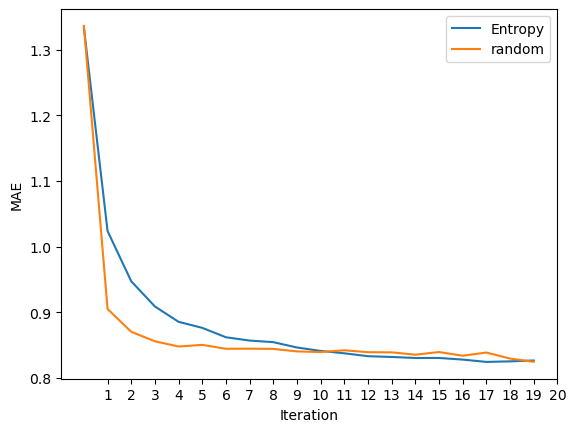

In [57]:
x = np.arange(20) 
fig, (ax1) = plt.subplots(1)
# fig.suptitle('Horizontally stacked subplots')
ax1.plot(x, entropy[1], label='Entropy')
ax1.plot(x, rand[1], label='random')

plt.legend(loc=1)
plt.xlabel("Iteration")
plt.ylabel("MAE")
plt.xticks(range(1, 21)) 
plt.show()

# plt.xticks(x, list_i)